In [61]:
# %load_ext autoreload
%autoreload 2

import os.path as osp
import janitor
import pypbo.perf as perf

import torch
import torch.nn as nn

import sys
sys.path.insert(0, osp.expanduser('~/git/former/'))

# from former.transformers import CTransformer
from former.transformers import TSTransformer

import mlstack.tscv as tscv
from mlstack import data_processing as dp
from mlstack.tscv import TimeSeriesEmbargoSplit
import mlstack.sklearn as mlsk

# 1. Load Data

In [62]:
data = osp.expanduser('~/data/etf.h5')
px = pd.read_hdf(data, key='close')

In [63]:
# import sys
# sys.path.insert(0, '/Users/zwl/git/mlstack')

In [64]:
rtns = perf.log_returns(px)

In [65]:
dfl = tscv.wide_to_long(rtns)

In [66]:
dfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40798 entries, 0 to 40797
Data columns (total 3 columns):
index    40798 non-null datetime64[ns]
name     40798 non-null object
value    40798 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


In [67]:
dfl.head()

,index,name,value
0,2003-04-14,EEM US Equity,0.012997
1,2003-04-15,EEM US Equity,0.011777
2,2003-04-16,EEM US Equity,0.011524
3,2003-04-17,EEM US Equity,0.007150
4,2003-04-21,EEM US Equity,-0.000460


In [68]:
feat_cols = ['LQD US Equity', 'IEF US Equity', 'EEM US Equity', 'SPY US Equity']

x = rtns[feat_cols].dropna(how='all')

In [69]:
flag = x.isnull().any(axis=1)

In [70]:
x.loc[flag].tail()

,LQD US Equity,IEF US Equity,EEM US Equity,SPY US Equity
index,,,,
2003-04-07,-0.001829,-0.002340,NaN,-0.001930
2003-04-08,0.003654,0.003743,NaN,0.001590
2003-04-09,0.003277,0.003380,NaN,-0.013242
2003-04-10,-0.003642,-0.002680,NaN,0.005500
2003-04-11,-0.003563,-0.002570,NaN,-0.004121


In [71]:
# safe to drop other NaN
x = x.dropna(how='any')

In [72]:
x = janitor.clean_names(x)

In [73]:
x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4095 entries, 2003-04-14 to 2019-07-19
Data columns (total 4 columns):
lqd_us_equity    4095 non-null float64
ief_us_equity    4095 non-null float64
eem_us_equity    4095 non-null float64
spy_us_equity    4095 non-null float64
dtypes: float64(4)
memory usage: 160.0 KB


### Examine Data

In [74]:
# now convert to sequence examples (t, dim)
seq_len = 12
dim = x.shape[1]

In [75]:
num_train = len(x) // seq_len
tail = len(x) % seq_len

In [76]:
num_train, tail

(341, 3)

In [77]:
# remove tail
if tail > 0:
    x = x.iloc[:-tail]
len(x)

4092

In [78]:
xx = x.values.reshape((-1, seq_len, dim))

In [79]:
xx.shape

(341, 12, 4)

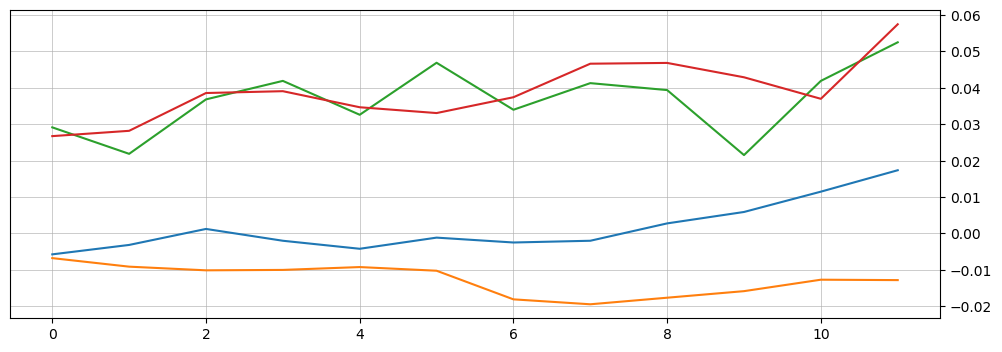

In [80]:
# long at random slice
plt.plot(range(12), xx[105].cumsum(axis=0))

## Test Transformer

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [82]:
b, t, e = xx.shape

In [83]:
former = TSTransformer(feature_dim=e, heads=4, depth=3, seq_length=t, 
                       num_classes=3)

In [84]:
former = former.to(device)

In [85]:
xa = torch.from_numpy(xx).to(device).float()

In [86]:
xa.shape

torch.Size([341, 12, 4])

In [87]:
xa.dtype

torch.float32

In [88]:
y = former.forward(xa)

In [89]:
y.shape

torch.Size([341, 3])

In [90]:
y

tensor([[-1.2263, -2.2835, -0.5031],
        [-1.2258, -2.2907, -0.5021],
        [-1.2241, -2.2850, -0.5038],
        ...,
        [-1.2267, -2.2871, -0.5022],
        [-1.2237, -2.2891, -0.5034],
        [-1.2259, -2.2879, -0.5025]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

### Regression Transformer

In [91]:
from former.transformers import TSRegTransformer

In [92]:
xa.shape

torch.Size([341, 12, 4])

In [93]:
reg = TSRegTransformer(feature_dim=e, heads=4, depth=3, seq_length=t, 
                       out_dim=4)

In [94]:
reg = reg.to(device)

In [95]:
y = reg.forward(xa)

In [96]:
y.shape

torch.Size([341, 4])

In [97]:
y[-1]

tensor([ 1.1637, -1.8173, -0.8295, -0.8165], device='cuda:0',
       grad_fn=<SelectBackward>)

## Next Steps

- learn `torch.utils.data.Dataset` and implement a `Dataset` object that feeds financial time series data.
    - [blog](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)
    - [docs](https://pytorch.org/docs/stable/data.html)
- Use `pytorch_lightning` to build a quick script to predict asset returns.


### Split data into features and labels

In [98]:
xa.shape

torch.Size([341, 12, 4])

In [99]:
# need to swap axies 
xb = torch.transpose(xa, 1, 2)
xb.shape

torch.Size([341, 4, 12])

In [100]:
x.shape

(4092, 4)

In [101]:
fx, fy = dp.sequential_xy_split_2d(x.T.values, train_len=7, target_len=3, ban_len=2)

In [102]:
fx.shape, fy.shape

((341, 4, 7), (341, 4, 3))

In [103]:
# validate data is correct, first item is fx is the same as the first 7 items of x
np.allclose(pd.DataFrame(fx[0].T), x.head(7))

True

In [104]:
# fy[0] should be the next 3 days data in x
np.allclose(pd.DataFrame(fy[0].T), x.iloc[7:10])

True

In [105]:
# validate ban is implemented correctly
np.allclose(pd.DataFrame(fx[1].T), x.iloc[12:19])

True

# 2. build financial dataset

## Split into Train, Test data

In [106]:
x.shape

(4092, 4)

In [107]:
rx, tx = mlsk.train_test_split_ts(x, ban_zone=5, train_size=.8, shuffle=False)

In [108]:
rx.tail()

,lqd_us_equity,ief_us_equity,eem_us_equity,spy_us_equity
index,,,,
2016-03-31,0.003963,0.003632,-0.000875,-0.002430
2016-04-01,0.003221,-0.000287,-0.002942,0.006789
2016-04-04,0.000084,0.001179,-0.012075,-0.003243
2016-04-05,0.003191,0.003983,-0.019765,-0.010042
2016-04-06,-0.000839,-0.002171,0.012027,0.010866


In [109]:
tx.head()

,lqd_us_equity,ief_us_equity,eem_us_equity,spy_us_equity
index,,,,
2016-04-21,-0.000418,-0.001642,-0.010020,-0.005393
2016-04-22,0.001087,-0.001095,-0.006055,0.000000
2016-04-25,-0.002343,-0.001098,-0.006434,-0.001724
2016-04-26,-0.000419,-0.002107,0.010763,0.001481
2016-04-27,0.006349,0.005487,0.006029,0.002060


In [110]:
train_len = int(x.shape[0] * .8)
train_len

3273

In [111]:
# split train and test sets
train, test = x[:train_len], x[train_len:]
len(train), len(test)

(3273, 819)

In [112]:
from mlstack import data_processing as dp
from torch.utils.data import Dataset

In [113]:
class TSDataset2D(Dataset):
    def __init__(self, data, seq_len: int, pred_len: int, ban_len: int, cumsum: bool):
        # data.shape == D, N
        assert data.ndim == 2
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.ban_len = ban_len
        self.cumsum = cumsum
        self.x, self.y = dp.sequential_xy_split_2d(data, train_len=seq_len, 
                                                   target_len=pred_len, 
                                                   ban_len=ban_len)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        _, D, N = self.x.shape
        x = self.x[idx]
        y = self.y[idx]
        
        if self.cumsum:
            y = y.sum(axis=1)
        
        return x.T, y

In [114]:
seq_len = 7
pred_len = 3
ban_len = 2

In [115]:
d = TSDataset2D(x.T.values, seq_len, pred_len, ban_len, cumsum=True)

In [116]:
len(d)

341

In [117]:
d[0][0].shape

(7, 4)

In [118]:
d[0][0]

array([[ 0.00054905, -0.00280899,  0.01299726,  0.02044281],
       [ 0.00182787,  0.00351188,  0.01177731,  0.00928832],
       [ 0.00673472,  0.0022182 ,  0.01152449, -0.01718916],
       [-0.00208832, -0.00128491,  0.0071503 ,  0.01473528],
       [ 0.00208832, -0.00186934, -0.00045977,  0.00100444],
       [ 0.00045338,  0.00023315,  0.00344313,  0.01867611],
       [ 0.00578554, -0.00046636,  0.00468653,  0.0091542 ]])

In [119]:
d[0][1]

array([ 0.00646904,  0.00641406, -0.02027486, -0.00423948])

In [120]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.nn import functional as F
from pytorch_lightning import Trainer

from test_tube import Experiment

In [121]:
train_set = TSDataset2D(rx.T.values, seq_len, pred_len, ban_len, cumsum=True)
valid_set = TSDataset2D(tx.T.values, seq_len, pred_len, ban_len, cumsum=True)

/home/zwl/git/mlstack/mlstack/data_processing.py:135: UserWarning: Time series tail size is 4, expecting at least 10. Last chunk is discarded.
  warnings.warn(msg)


In [122]:
train_set[0]

(array([[ 0.00054905, -0.00280899,  0.01299726,  0.02044281],
        [ 0.00182787,  0.00351188,  0.01177731,  0.00928832],
        [ 0.00673472,  0.0022182 ,  0.01152449, -0.01718916],
        [-0.00208832, -0.00128491,  0.0071503 ,  0.01473528],
        [ 0.00208832, -0.00186934, -0.00045977,  0.00100444],
        [ 0.00045338,  0.00023315,  0.00344313,  0.01867611],
        [ 0.00578554, -0.00046636,  0.00468653,  0.0091542 ]]),
 array([ 0.00646904,  0.00641406, -0.02027486, -0.00423948]))

In [123]:
# test data loader
u = DataLoader(train_set, batch_size=128, shuffle=False)
u

In [124]:
class FinNet(pl.LightningModule):
    def __init__(self, dim: int, seq_len: int, heads: int, n_layers: int, out_dim: int, 
                 batch_size: int = 32):
        super().__init__()
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.tsformer = TSRegTransformer(feature_dim=dim, 
                                         heads=heads, 
                                         depth=n_layers, 
                                         seq_length=seq_len,
                                         out_dim=out_dim)
        
    def forward(self, x):
        return self.tsformer(x)
    
    # TODO: how to use Transformer for regression problems. 
    # or convert y into a classification problem.
    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        # don't reduce loss here, this is so that in multi-gpu training
        # we don't get a scaler loss warning
        # for multi-gpu training, better to run reduction outside
        # https://discuss.pytorch.org/t/mse-loss-gpu-warning/24782/2
        # https://discuss.pytorch.org/t/how-to-fix-gathering-dim-0-warning-in-multi-gpu-dataparallel-setting/41733
        # reduction is then handled in Trainer
        return {'loss': F.l1_loss(y_hat, y.float(), reduction='none')}
#         return {'loss': F.l1_loss(y_hat, y.float())}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': F.l1_loss(y_hat, y.float(), reduction='none')}
#         return {'val_loss': F.l1_loss(y_hat, y.float()).mean(axis=1)}

    def validation_end(self, outputs):
        # OPTIONAL
#         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_loss = (
            torch.cat(
                [x['val_loss'].mean(axis=1, keepdim=True) for x in outputs],
                axis=0,
            ).mean()
        )
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        return torch.optim.Adam(self.parameters(), lr=0.02)

    @pl.data_loader
    def tng_dataloader(self):
        # REQUIRED
        return DataLoader(train_set, batch_size=self.batch_size, shuffle=False)

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(valid_set, batch_size=self.batch_size, shuffle=False)

#     @pl.data_loader
#     def test_dataloader(self):
#         # OPTIONAL
#         return DataLoader(train_set, batch_size=128, shuffle=False)

In [125]:
model = FinNet(dim=x.shape[1], seq_len=seq_len, heads=4, n_layers=2, 
               out_dim=x.shape[1], batch_size=16).to(device)

In [130]:
# most basic trainer, uses good defaults

# tensorboard --logdir /Users/zwl/tmp/tb

exp = Experiment(save_dir='/home/zwl/tmp/tb')
trainer = Trainer(max_nb_epochs=2, experiment=exp, 
                  gpus=[0, 1], 
                  distributed_backend='dp')
trainer.fit(model)   

  0%|          | 0/5 [00:00<?, ?it/s]

gpu available: True, used: True
VISIBLE GPUS: 0,1
                                       Name              Type  Params
0                                  tsformer  TSRegTransformer     896
1                    tsformer.pos_embedding         Embedding      28
2                          tsformer.tblocks        Sequential     848
3                        tsformer.tblocks.0  TransformerBlock     424
4              tsformer.tblocks.0.attention     SelfAttention     260
5       tsformer.tblocks.0.attention.tokeys            Linear      64
6    tsformer.tblocks.0.attention.toqueries            Linear      64
7     tsformer.tblocks.0.attention.tovalues            Linear      64
8   tsformer.tblocks.0.attention.unifyheads            Linear      68
9                  tsformer.tblocks.0.norm1         LayerNorm       8
10                 tsformer.tblocks.0.norm2         LayerNorm       8
11                    tsformer.tblocks.0.ff        Sequential     148
12                  tsformer.tblocks.0.f

100%|██████████| 22/22 [00:00<00:00,  6.34it/s, avg_val_loss=0.0154, batch_nb=16, epoch=1, gpu=0, loss=0.094, v_nb=55]

1

100%|██████████| 22/22 [00:14<00:00,  6.34it/s, avg_val_loss=0.0154, batch_nb=16, epoch=1, gpu=0, loss=0.094, v_nb=55]

In [152]:
_ = model.eval()

100%|██████████| 22/22 [00:19<00:00, 27.49it/s, avg_val_loss=0.00809, batch_nb=16, epoch=29, gpu=0, loss=0.013, v_nb=26]

In [156]:
u, v = valid_set[-33]

In [157]:
model.forward(torch.from_numpy(u.reshape(1, -1, u.shape[-1])).to(device))

tensor([[-0.0019,  0.0006, -0.0050,  0.0017]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [158]:
v

array([ 0.00453255,  0.00283017, -0.00215261, -0.00244336])

## Try a simpler model

In [93]:
import sklearn.linear_model as lm

In [95]:
rx.head()

,lqd_us_equity,ief_us_equity,eem_us_equity,spy_us_equity
index,,,,
2003-04-14,0.000549,-0.002809,0.012997,0.020443
2003-04-15,0.001828,0.003512,0.011777,0.009288
2003-04-16,0.006735,0.002218,0.011524,-0.017189
2003-04-17,-0.002088,-0.001285,0.007150,0.014735
2003-04-21,0.002088,-0.001869,-0.000460,0.001004


In [1]:
import math

In [3]:
e = 125

In [4]:
%%timeit
math.sqrt(e)

108 ns ± 1.23 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [5]:
%%timeit
np.sqrt(e)

906 ns ± 9.27 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [6]:
%%timeit
e ** ( 1/ 4)

134 ns ± 0.24 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [7]:
%%timeit
math.pow(e, .25)

204 ns ± 8.58 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
%%timeit
math.sqrt(math.sqrt(e))

202 ns ± 8.45 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [56]:
a.dtype

torch.float32

In [58]:
torch.arange(5, dtype=a.dtype).dtype

torch.float32

In [60]:
a.float().dtype

torch.float32